In [2]:
# import requests
import torch
# import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
file = "nomes_br.csv"
# if not os.path.isfile(file):
#     res = requests.get(
#         "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt", 
#         timeout=60
#     )
#     with open("names.txt", 'w+', encoding='utf-8') as f:
#         f.write(res.text)

words = []
with open(file, 'r', encoding='utf-8') as f:
    words = f.read().lower().splitlines()
words[:10]

['adao',
 'adelina',
 'adelson',
 'ademar',
 'ademir',
 'adenilson',
 'adilson',
 'adriana',
 'adriano',
 'adriele']

In [4]:
#build the vocabulary os chars and mapping to/from integers
chars = ['.']+sorted(list(set(''.join(words))))
ctoi = {c:i for i,c in enumerate(chars)}
itoc = {i:c for c,i in ctoi.items()}
print(itoc)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [5]:
# block_size = 3 # context lenght: how many chars do we take to predict the next?
# X, Y = [], []
# for w in words:
#     # print(w)
#     context = [0] * block_size
#     for ch in w + '.':
#         ix = ctoi[ch]
#         X.append(context)
#         Y.append(ix)
#         # print(''.join(itoc[i] for i in context), '----->', itoc[ix])
#         context = context[1:] + [ix]

# X = torch.tensor(X)
# Y = torch.tensor(Y)

In [6]:
# build the dataset

block_size = 4
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = ctoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# training split, dev/validation split, test split
# 80%, 10% , 10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([205825, 4]) torch.Size([205825])
torch.Size([25842, 4]) torch.Size([25842])
torch.Size([25823, 4]) torch.Size([25823])


In [30]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)

W1 = torch.randn((C.shape[1]*block_size, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [31]:
sum(p.nelement() for p in parameters)

20697

In [32]:
for p in parameters:
    p.requires_grad = True

In [33]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

In [34]:
for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)

    # foward pass
    emb = C[Xtr[ix]] # [32, 3, 2]
    # like to do (emb @ W1 + b1) but (!(32, 3, 2) @ (6, 100)! + (100))
    # torch.cat(torch.unbind(emb, 1), dim=1).shape # one way
    h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    #update
    lr = 0.1 if i < 100000 else (0.05 if i < 150000 else 0.01) # lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track the loss
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

1.861379861831665


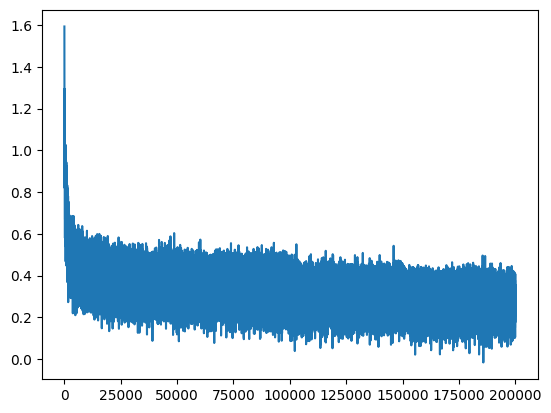

In [35]:
# plt.plot(lri, lossi)
plt.plot(stepi, lossi)

In [36]:
emb = C[Xtr] # [32, 3, 2]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

1.8962651491165161

In [37]:
emb = C[Xdev] # [32, 3, 2]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

1.9566699266433716

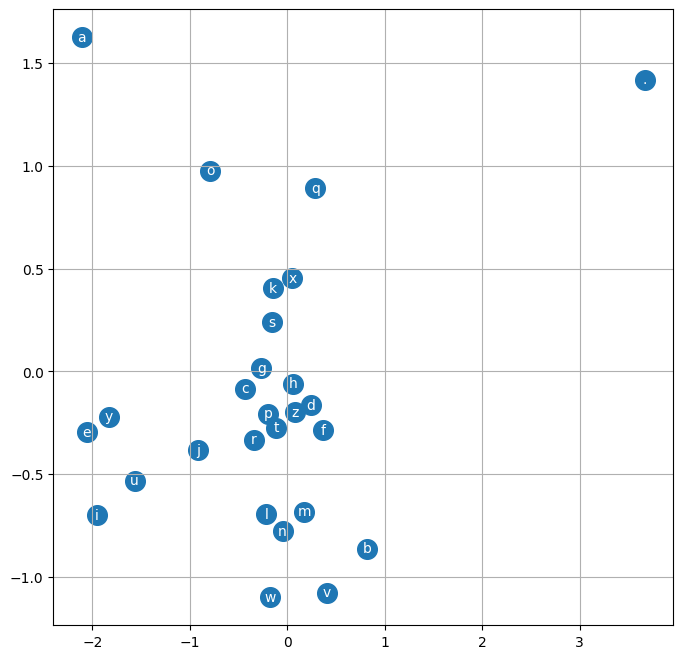

In [38]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color="white")
plt.grid("minor")

In [39]:
# sample from model
g1 = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itoc[i] for i in out))

eria.
glean.
seel.
nice.
alcienerso.
jerlei.
aderido.
liunelione.
leieineana.
arlelly.
marqua.
nosadgorisvaliel.
jocir.
jeovannie.
crius.
marda.
jaquelmerson.
esmes.
ludiane.
nikkyko.
